# 1 整体描述性统计情况

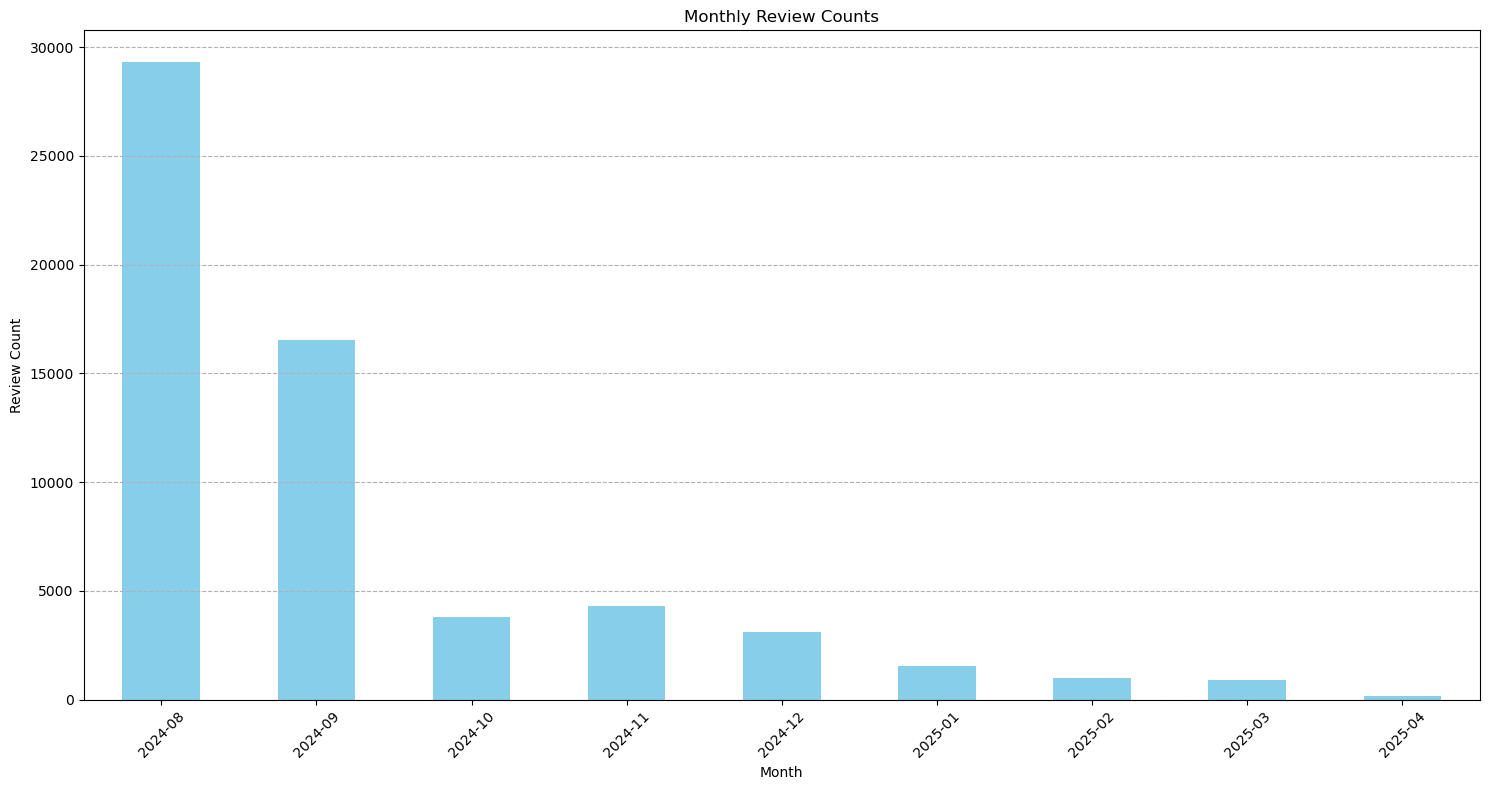

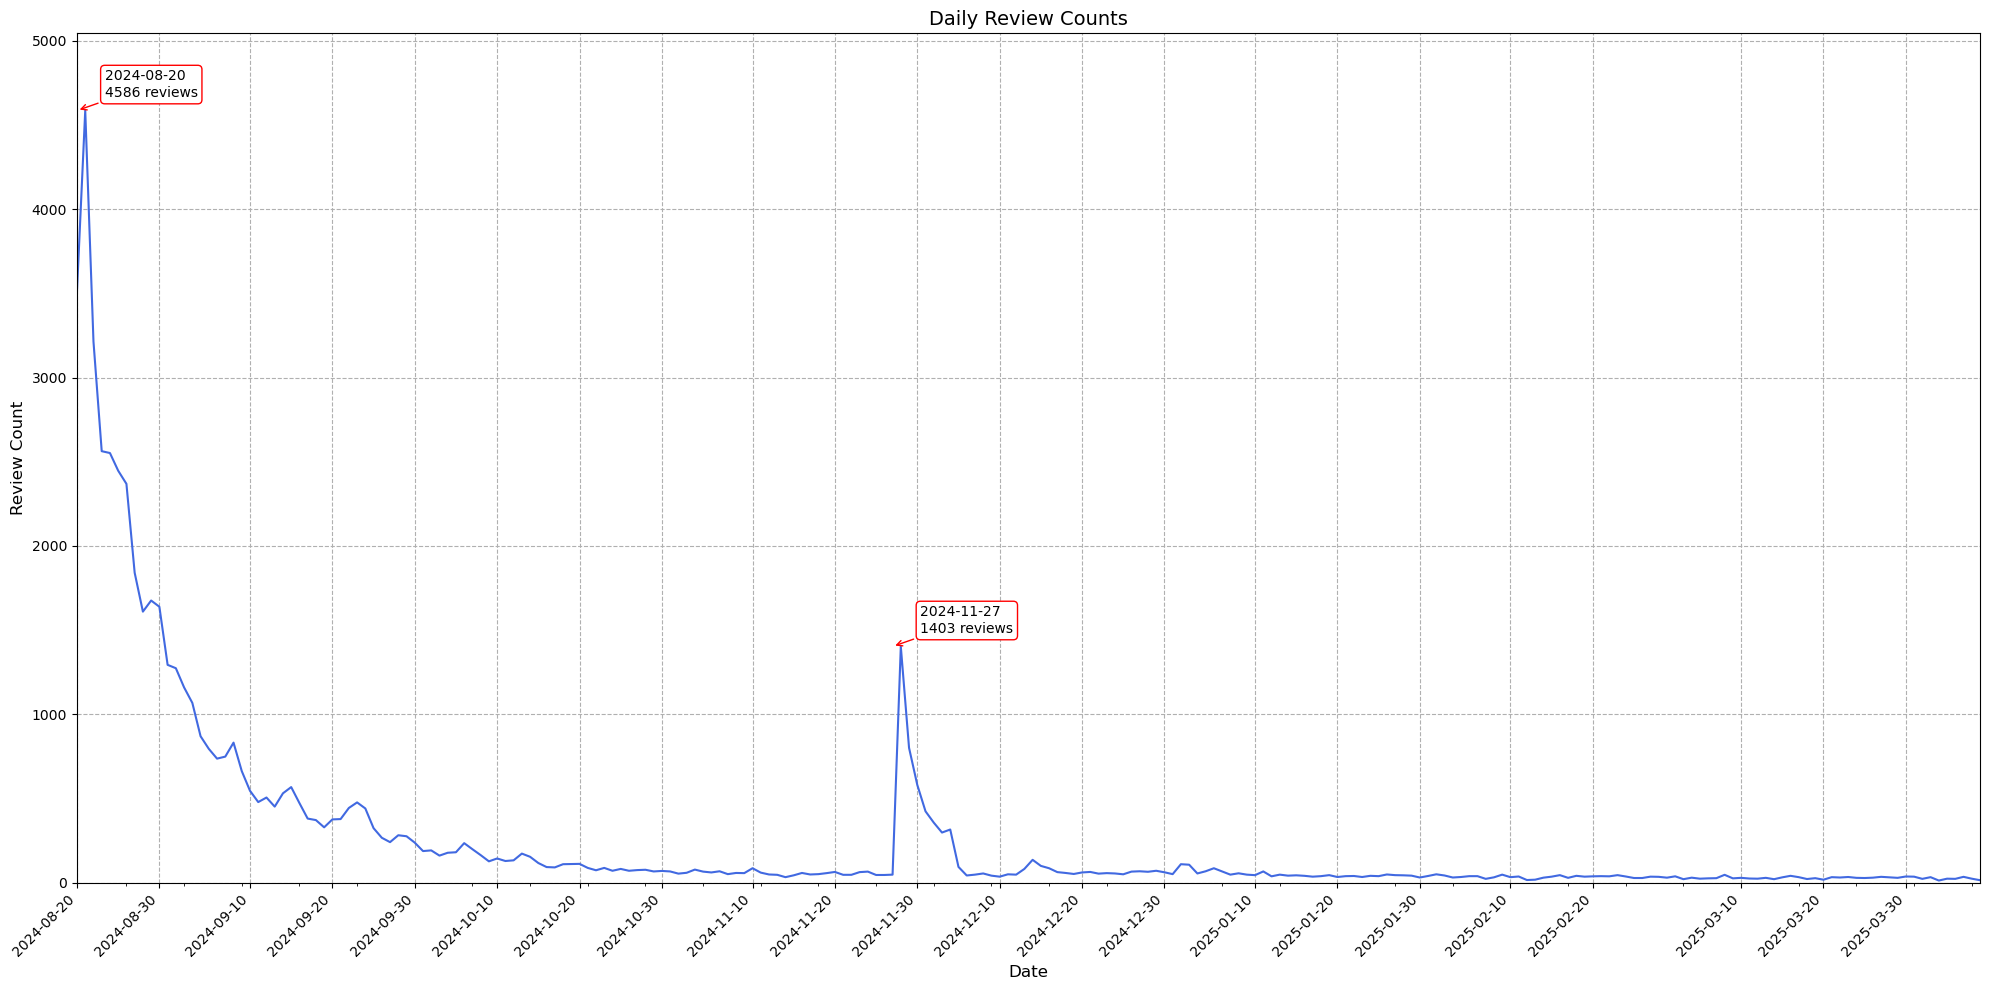

In [1]:
# ---------------------------
# 描述性统计内容
# ---------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
import os

# 创建图片保存目录
os.makedirs('image', exist_ok=True)

# 读取数据
df = pd.read_csv('wukong_english_filterRecent_V2.csv')  # 修改为你的文件路径

# 转换时区（UTC+8）
df['beijing_time'] = pd.to_datetime(df['timestamp_created'], unit='s') \
                     .dt.tz_localize('UTC') \
                     .dt.tz_convert(timezone('Asia/Shanghai'))

# ---------------------------
# 1. 按月统计的条形图（调整高度）
# ---------------------------
plt.figure(figsize=(15, 8))  # 高度从6增加到8
monthly_counts = df.resample('M', on='beijing_time')['recommendationid'].count()
monthly_counts.index = monthly_counts.index.strftime('%Y-%m')
monthly_counts.plot(kind='bar', color='skyblue')

plt.title('Monthly Review Counts')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# 保存图片
plt.savefig('image/monthly_reviews_V2.png', dpi=300, bbox_inches='tight')
plt.show()


# ---------------------------
# 日统计折线图（含标注）
# ---------------------------
plt.figure(figsize=(20, 10))
daily_counts = df.resample('D', on='beijing_time')['recommendationid'].count()
daily_counts.plot(kind='line', color='royalblue')

# 找到全局最大值
max_all = daily_counts.idxmax().tz_convert(None)  # 去除时区信息
max_all_value = daily_counts.max()

# 找到2024-11-20之后的最高值
cutoff_date = pd.Timestamp('2024-11-20').tz_localize('Asia/Shanghai')
post_counts = daily_counts[daily_counts.index >= cutoff_date]
if not post_counts.empty:
    max_post = post_counts.idxmax().tz_convert(None)
    max_post_value = post_counts.max()
else:
    max_post = None

# 绘制标注函数
def add_annotation(date, value, label):
    ax = plt.gca()
    ax.annotate(
        f'{date.date()}\n{value} reviews',
        xy=(date, value),
        xytext=(20, 10),  # 右侧偏移量
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", color='red'),
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', lw=1),
        fontsize=10,
        color='black'
    )

# 添加标注
add_annotation(max_all, max_all_value, "All-time Peak")

if max_post is not None:
    add_annotation(max_post, max_post_value, "Post-2024-11-20 Peak")

# 配置图形
plt.title('Daily Review Counts', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count', fontsize=12)

# 配置x轴
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[10,20,30]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')
plt.grid(linestyle='--')

# 调整显示范围
plt.ylim(0, max_all_value * 1.1)  # 留出标注空间

# 保存和显示
plt.tight_layout()
plt.savefig('image/daily_reviews_annotated_V2.png', dpi=300, bbox_inches='tight')
plt.show()

# 2 情感分析板块

## 2.1 评论内容数据清洗和固定部分

In [2]:
# ---------------------------
# 基础清洗（不进行词形还原）
# ---------------------------
import pandas as pd
import re
import spacy
from tqdm import tqdm
tqdm.pandas()

# 加载spaCy模型（仅用于词性还原部分）
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_review(text):
    # 基础清洗
    if pd.isna(text):
        return ""
    
    # 去除非英文内容
    text = re.sub(r'<.*?>', '', text)  # 移除HTML标签
    text = re.sub(r'http\S+', '', text)  # 移除URL
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # 移除非ASCII字符（包括中文）
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF]', '', text)  # 移除表情符号
    
    # 文本标准化
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # 保留字母数字和空格
    text = re.sub(r'\s+', ' ', text).strip().lower()
    
    return text

# 处理数据
df = pd.read_csv('wukong_english_filterRecent_V2.csv')
print("原始数据示例:\n", df['review'].head(3))

# 清洗评论列（仅基础清洗）
df['review'] = df['review'].progress_apply(clean_review)

# 步骤1：检查并处理缺失值
print("缺失值数量:", df['review'].isna().sum())  # 确认缺失值数量
df['review'] = df['review'].fillna('')

# 步骤2：强制转换为字符串类型
df['review'] = df['review'].astype(str)

# 步骤3：验证数据类型
print("当前数据类型:", df['review'].dtype)  # 应显示object
print("缺失值数量:", df['review'].isna().sum())

# 保存基础清洗后的结果
df.to_csv('wukong_english_filterRecent_V2_washBase.csv', 
          index=False,
          encoding='utf-8-sig')  # 添加编码参数

print("基础清洗完成，示例输出:\n", df['review'].head(3))

原始数据示例:
 0    This game is a really good and cinematic game ...
1                                                  NB!
2                                   Best game of 2024.
Name: review, dtype: object


100%|██████████| 60734/60734 [00:00<00:00, 80614.10it/s]


缺失值数量: 0
当前数据类型: object
缺失值数量: 0
基础清洗完成，示例输出:
 0    this game is a really good and cinematic game ...
1                                                   nb
2                                    best game of 2024
Name: review, dtype: object


In [3]:
# ---------------------------
# 无词性还原 - 时间处理
# ---------------------------
import pandas as pd
import numpy as np
from datetime import datetime

# 读取清洗后的数据
# df = pd.read_csv('wukong_english_filterRecent_V2_washBase.csv')
df = pd.read_csv('wukong_english_filterRecent_V2_washBase.csv')
df['review'] = df['review'].astype(str)  # 强制转换为字符串

# 时间处理
df['date'] = pd.to_datetime(df['timestamp_created'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')

## 2.2 情感分析及离散化情感判断

In [4]:
# ---------------------------
# 无词性还原 - VADER情感分析
# ---------------------------
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
tqdm.pandas()  # 关键修复点：启用pandas进度条支持

print("正在执行VADER情感分析...")
sia = SentimentIntensityAnalyzer()
df['sentiment_vader'] = df['review'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

正在执行VADER情感分析...


100%|██████████| 60734/60734 [00:22<00:00, 2665.05it/s]


In [5]:
# ---------------------------
# 无词性还原 - 大模型情感分析
# ---------------------------
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# 初始化模型和分词器
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def count_tokens(text):
    """计算文本的token数量"""
    return len(tokenizer.tokenize(text))

def process_short_text(texts):
    """处理短文本（<512 tokens）"""
    inputs = tokenizer(texts, 
                     padding=True, 
                     truncation=True, 
                     max_length=512,
                     return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs.to(device))
    
    return torch.argmax(outputs.logits, dim=1).cpu().numpy() + 1

def process_long_text(text, window_size=400, stride=200):
    """处理长文本（>=512 tokens）的滑动窗口方法"""
    tokens = tokenizer.encode(text, truncation=False)
    
    windows = []
    for i in range(0, len(tokens), stride):
        window = tokens[i:i+window_size]
        windows.append(tokenizer.decode(window))
    
    window_scores = process_short_text(windows)
    return np.mean(window_scores)

def hybrid_processing(chunk):
    """混合处理逻辑"""
    results = []
    for text in chunk:
        if count_tokens(text) < 512:
            # 短文本直接处理
            results.append(process_short_text([text])[0])
        else:
            # 长文本使用滑动窗口
            results.append(process_long_text(text))
    return np.array(results)

# 分块处理数据
chunks = np.array_split(df['review'].fillna(''), 10)
df['sentiment_hybrid'] = np.concatenate([hybrid_processing(chunk) for chunk in tqdm(chunks)])

  0%|          | 0/10 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\envs\T-10\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 10/10 [07:35<00:00, 45.51s/it]


In [6]:
# 统一分类逻辑
def classify_sentiment(score, method='vader'):
    if method == 'vader':
        if score >= 0.05: return 'positive'
        elif score <= -0.05: return 'negative'
        else: return 'neutral'
    else: # BERT
        if score >=4: return 'positive'
        elif score <=2: return 'negative'
        else: return 'neutral'

df['label_vader'] = df['sentiment_vader'].apply(classify_sentiment)
df['label_hybrid'] = df['sentiment_hybrid'].apply(lambda x: classify_sentiment(x, 'hybrid'))

In [7]:
# 将 DataFrame 保存为 CSV 文件
df.to_csv('sentiment_analysis_results_V20250412.csv', index=False, encoding='utf-8-sig')

## 2.3 情感分析可视化

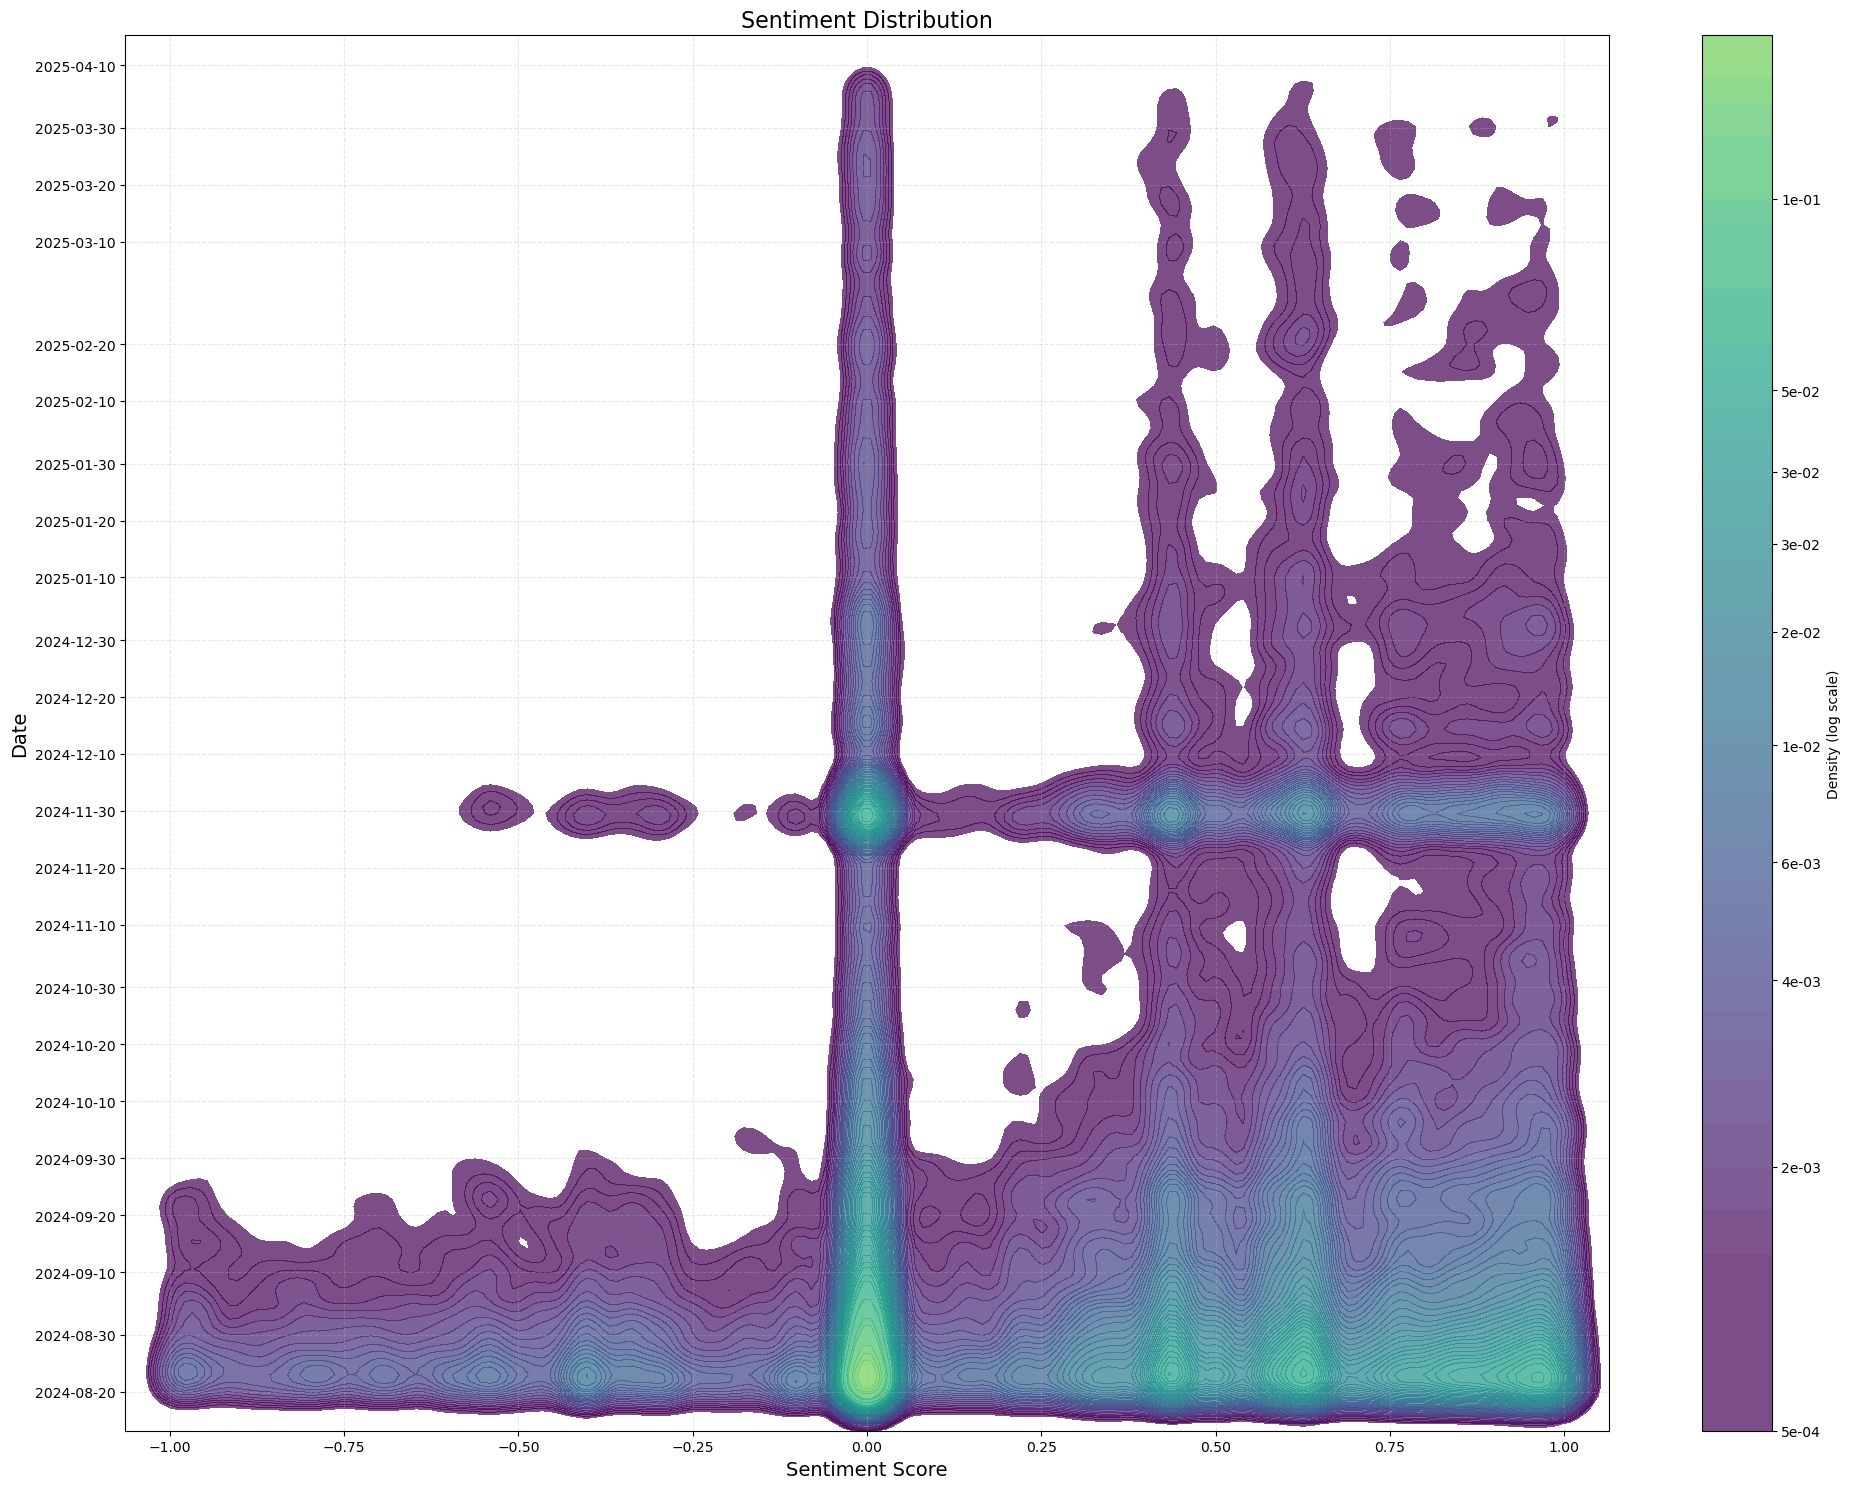

In [8]:
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
ax = plt.gca()

# 转换时间为数值格式（关键修复步骤）
date_num = mdates.date2num(df['date'])

# 优化核密度估计参数
kde = sns.kdeplot(
    x=df['sentiment_vader'],
    y=date_num,
    cmap="viridis",
    fill=True,
    levels=50,
    bw_adjust=0.3,
    norm=LogNorm(vmin=1e-3, vmax=1),  # 显式设置范围
    alpha=0.7,
    cbar=True,  # 确保启用颜色条
    cbar_kws={
        'label': 'Density (log scale)',
        'orientation': 'vertical',
        'format': '%.0e'  # 科学计数法显示
    }
)

# 正确获取颜色条引用（关键修复）
cbar = ax.collections[0].colorbar  # 从ax获取而不是kde

# 配置颜色条标签
if cbar:
    cbar.set_label('Density (log scale)', fontsize=12)
    cbar.ax.yaxis.set_label_coords(3, 0.5)  # 调整标签位置

# 日期格式化（保持原有逻辑）
ax.yaxis.set_major_locator(mdates.DayLocator(bymonthday=[10,20,30]))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 其他优化设置
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Date', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('image/sentiment_kde_fixed_V0412.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\xjw\AppData\Local\Temp\ipykernel_120532\617480932.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['date'].dt.to_period('W-Mon')  # 以周一作为周起始


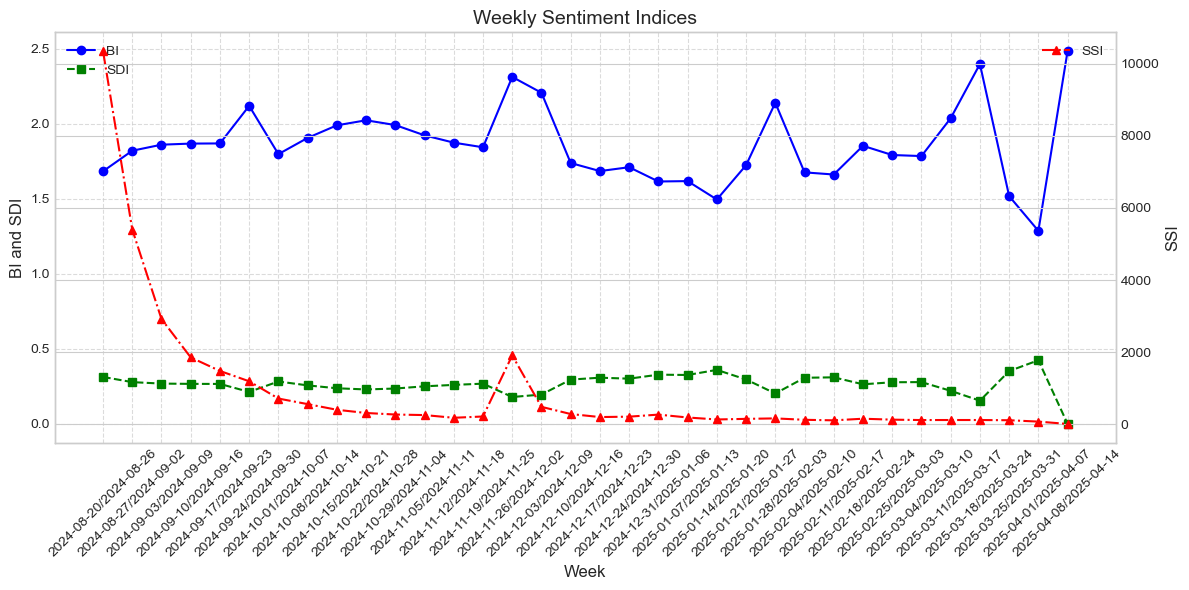

In [10]:
# ---------------------------
# 无词性还原 - 三则指数分析
# ---------------------------

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# 周次计算
df['week'] = df['date'].dt.to_period('W-Mon')  # 以周一作为周起始

# 聚合计算
weekly = df.groupby('week')['label_vader'].value_counts().unstack().fillna(0)
weekly['SSI'] = weekly.get('positive', 0) - weekly.get('negative', 0)
weekly['BI'] = np.log((weekly.get('positive', 0) + 1) / (weekly.get('negative', 0) + 1))
weekly['SDI'] = abs(1 - abs((weekly.get('negative', 0) - weekly.get('positive', 0)) / 
                           (weekly.get('positive', 0) + weekly.get('negative', 0))))

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')

# 创建图形和左侧轴
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制 BI 和 SDI 在左侧轴
ax1.plot(weekly.index.astype(str), weekly['BI'], label='BI', color='blue', marker='o', linestyle='-', linewidth=1.5)
ax1.plot(weekly.index.astype(str), weekly['SDI'], label='SDI', color='green', marker='s', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Week', fontsize=12, fontfamily='sans-serif')
ax1.set_ylabel('BI and SDI', fontsize=12, fontfamily='sans-serif')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7)

# 创建右侧轴
ax2 = ax1.twinx()

# 绘制 SSI 在右侧轴
ax2.plot(weekly.index.astype(str), weekly['SSI'], label='SSI', color='red', marker='^', linestyle='-.', linewidth=1.5)
ax2.set_ylabel('SSI', fontsize=12, fontfamily='sans-serif')

# 设置图例
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# 设置标题
plt.title('Weekly Sentiment Indices', fontsize=14, fontfamily='sans-serif')

# 调整布局
plt.tight_layout()

# 保存图表
plt.savefig('image/weekly_sentiment_index.png', dpi=300)

# 显示图表
plt.show()

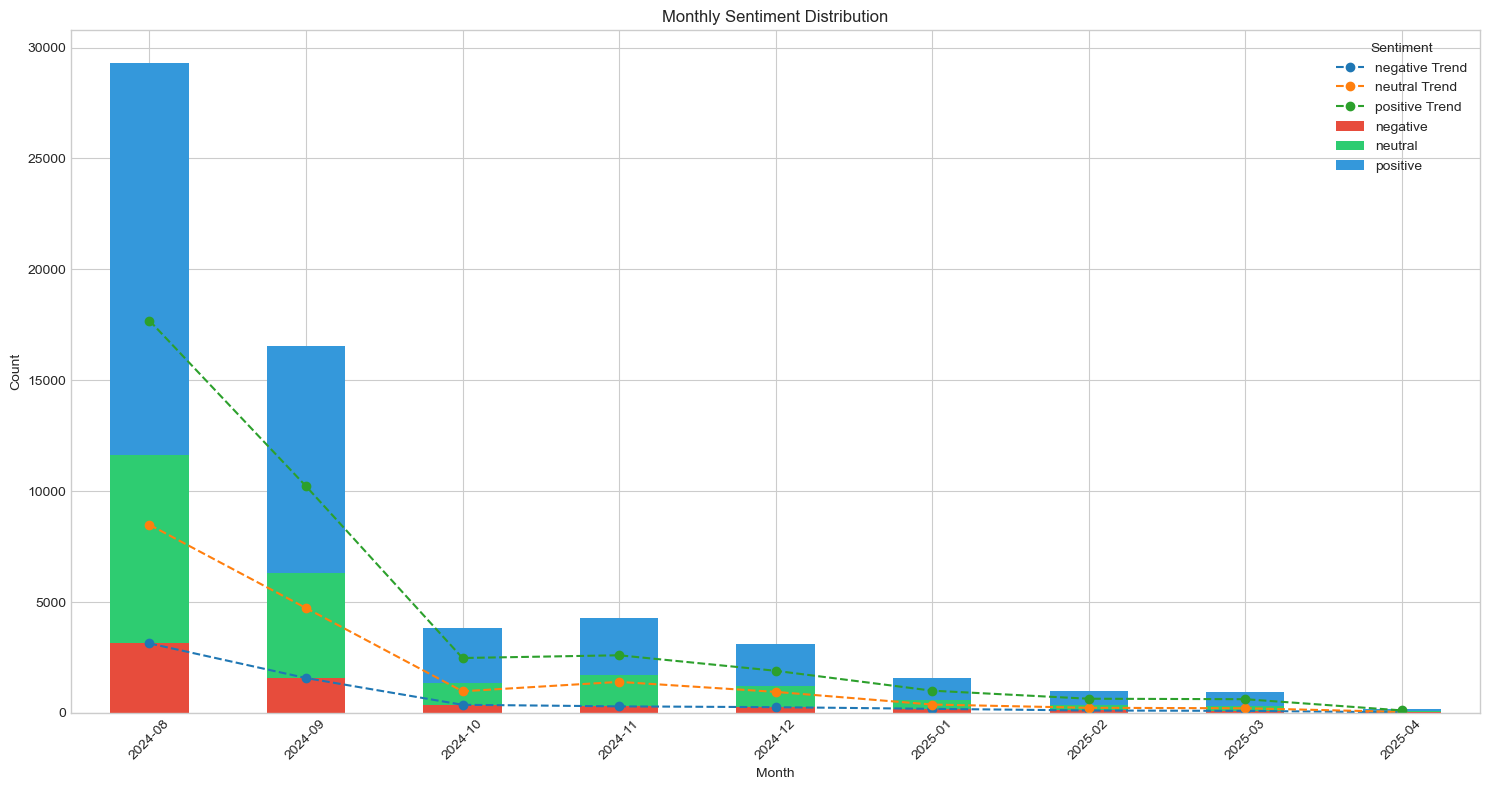

In [11]:
# ---------------------------
# 无词性还原 - 堆叠条形图
# ---------------------------
import pandas as pd
import matplotlib.pyplot as plt

#假设你的数据已经准备好
monthly = df.groupby([pd.Grouper(key='date', freq='M'), 'label_vader']).size().unstack()

ax = monthly.plot(kind='bar', stacked=True, 
                 color=['#e74c3c', '#2ecc71', '#3498db'], 
                 figsize=(15, 8))

plt.title('Monthly Sentiment Distribution')
plt.xlabel('Month')
plt.ylabel('Count')

# 设置 x 轴的刻度和标签
plt.xticks(ticks=range(len(monthly.index)),  # 设置刻度位置
           labels=monthly.index.strftime('%Y-%m'),  # 设置刻度标签
           rotation=45)  # 设置标签旋转角度

# 预定义颜色
colors = ['#e74c3c', '#2ecc71', '#3498db']

# 为每种情感添加趋势线
for i, col in enumerate(monthly.columns):
    # 使用每种情感的原始数值
    values = monthly[col].values
    
    # 绘制趋势线
    ax.plot(range(len(monthly.index)), values, 
            linestyle='--',  # 实线
            marker='o',  # 添加标记点
            #color=colors[i],  # 使用预定义的颜色
            label=f'{col} Trend')

plt.legend(title='Sentiment')
plt.tight_layout()  # 自动调整布局
plt.savefig('image/monthly_sentiment.png', dpi=300)
plt.show()

## 2.4 词形还原备用

In [12]:
# ---------------------------
# 词形还原处理
# ---------------------------
import pandas as pd
import spacy
from tqdm import tqdm
tqdm.pandas()

# 加载spaCy模型
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_review(text):
    # 词形还原处理
    doc = nlp(text)
    processed = [
        token.lemma_ for token in doc
        if not token.is_stop and 
           not token.is_punct and 
           len(token.lemma_) > 2
    ]
    
    return ' '.join(processed)

# 读取基础清洗后的数据
df = pd.read_csv('wukong_english_filterRecent_V2_washBase.csv')
df['review'] = df['review'].astype(str)  # 强制转换为字符串

print("基础清洗后的数据示例:\n", df['review'].head(3))

# 进行词形还原处理
df['review'] = df['review'].progress_apply(lemmatize_review)

# 保存词形还原后的结果
df.to_csv('wukong_english_filterRecent_V2_washPro_0412.csv', 
          index=False,
          encoding='utf-8-sig')  # 添加编码参数

print("词形还原完成，示例输出:\n", df['review'].head(3))

基础清洗后的数据示例:
 0    this game is a really good and cinematic game ...
1                                                   nb
2                                    best game of 2024
Name: review, dtype: object


100%|██████████| 60734/60734 [01:55<00:00, 527.59it/s]


词形还原完成，示例输出:
 0    game good cinematic game highly suggest get wo...
1                                                     
2                                       good game 2024
Name: review, dtype: object


# 3 词频与主题分析

## 3.1 词频分析与词云

In [13]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import numpy as np
from PIL import Image
import os

# ================= 用户配置区域 =================
EXCLUDE_WORDS = {  # 在此处添加要排除的词汇（小写）
    'game', 'play', 'just', 'get'
}
# ==============================================

# 加载数据
df = pd.read_csv('wukong_english_filterRecent_V2_washPro_0412.csv')  # 修改为你的文件名
df['review'] = df['review'].astype(str)  # 强制转换为字符串
text = ' '.join(df['review'].astype(str))

# 预处理流水线
def process_text(text, exclude_words=None):
    # 标准化处理
    words = text.lower().split()
    
    # 停用词过滤
    filtered = [w for w in words if w not in STOPWORDS]
    
    # 用户自定义排除
    if exclude_words:
        filtered = [w for w in filtered if w not in exclude_words]
    
    return filtered

# 首次处理（带排除）
processed_words = process_text(text, EXCLUDE_WORDS)

# 生成可调整的词频报告
def show_word_freq(words, top_n=30):
    counter = Counter(words)
    print(f"\n当前有效词汇总量: {len(counter)}")
    print(f"Top {top_n} 高频词:")
    print("-"*30)
    for i, (word, count) in enumerate(counter.most_common(top_n), 1):
        print(f"{i:>2}. {word:<15} {count}")
    print("-"*30)

# 交互式验证
while True:
    show_word_freq(processed_words)
    
    # 用户决策
    choice = input("是否需要调整排除词？(y/n): ").lower()
    if choice != 'y':
        break
    
    # 动态添加新排除词
    new_excludes = input("请输入要新增排除的词汇（空格分隔）: ").lower().split()
    EXCLUDE_WORDS.update(new_excludes)
    processed_words = process_text(text, EXCLUDE_WORDS)

# 最终生成词云
mask = np.array(Image.open("monkey_king.png").convert('L'))
mask = np.where(mask > 200, 0, 255)

wc = WordCloud(
    mask=mask,
    background_color=None,
    mode="RGBA",
    max_words=800,
    collocations=False,
    stopwords=EXCLUDE_WORDS  # 直接使用 EXCLUDE_WORDS
).generate(' '.join(processed_words))

# 保存结果
os.makedirs('image', exist_ok=True)
wc.to_file('image/final_wordcloud.png')
print("\n最终词云已保存至 image/final_wordcloud.png")


当前有效词汇总量: 24006
Top 30 高频词:
------------------------------
 1. good            16656
 2. boss            14281
 3. great           8228
 4. story           7942
 5. monkey          7665
 6. combat          6730
 7. fun             6683
 8. monke           6435
 9. time            6119
10. feel            5985
11. amazing         5439
12. fight           5339
13. soul            5252
14. graphic         5161
15. wukong          5161
16. love            4220
17. year            4186
18. gameplay        4029
19. chapter         3975
20. look            3732
21. goty            3610
22. hard            3577
23. nan             3396
24. design          3384
25. recommend       3349
26. chinese         3271
27. don             3268
28. experience      3118
29. lot             3013
30. black           2916
------------------------------


是否需要调整排除词？(y/n):  y
请输入要新增排除的词汇（空格分隔）:  monke nan don



当前有效词汇总量: 24003
Top 30 高频词:
------------------------------
 1. good            16656
 2. boss            14281
 3. great           8228
 4. story           7942
 5. monkey          7665
 6. combat          6730
 7. fun             6683
 8. time            6119
 9. feel            5985
10. amazing         5439
11. fight           5339
12. soul            5252
13. graphic         5161
14. wukong          5161
15. love            4220
16. year            4186
17. gameplay        4029
18. chapter         3975
19. look            3732
20. goty            3610
21. hard            3577
22. design          3384
23. recommend       3349
24. chinese         3271
25. experience      3118
26. lot             3013
27. black           2916
28. myth            2893
29. beautiful       2767
30. far             2767
------------------------------


是否需要调整排除词？(y/n):  y
请输入要新增排除的词汇（空格分隔）:  lot far



当前有效词汇总量: 24001
Top 30 高频词:
------------------------------
 1. good            16656
 2. boss            14281
 3. great           8228
 4. story           7942
 5. monkey          7665
 6. combat          6730
 7. fun             6683
 8. time            6119
 9. feel            5985
10. amazing         5439
11. fight           5339
12. soul            5252
13. graphic         5161
14. wukong          5161
15. love            4220
16. year            4186
17. gameplay        4029
18. chapter         3975
19. look            3732
20. goty            3610
21. hard            3577
22. design          3384
23. recommend       3349
24. chinese         3271
25. experience      3118
26. black           2916
27. myth            2893
28. beautiful       2767
29. journey         2713
30. hour            2680
------------------------------


是否需要调整排除词？(y/n):  n



最终词云已保存至 image/final_wordcloud.png


## 3.2 二次适应性清洗与传统LDA分析

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xjw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xjw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xjw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


text finished

preprocess finished

corpora finished

1 : 1345.4219
2 : 1266.2556
3 : 1247.1487
4 : 1234.7255
5 : 1294.2695
6 : 1301.0857
7 : 1365.1371
8 : 1446.0016
9 : 1616.3058
10 : 1813.4676
plot corpora finished

train_LDA finished

[(0, '0.418*"monkey" + 0.021*"good" + 0.021*"return" + 0.020*"stick" + 0.019*"reject" + 0.015*"king" + 0.014*"embrace" + 0.012*"bonk" + 0.010*"grind" + 0.009*"long"'), (1, '0.040*"wukong" + 0.025*"chinese" + 0.022*"myth" + 0.022*"black" + 0.020*"journey" + 0.020*"game" + 0.017*"west" + 0.013*"combat" + 0.012*"world" + 0.012*"experience"'), (2, '0.151*"game" + 0.027*"good" + 0.021*"great" + 0.021*"like" + 0.017*"play" + 0.015*"amazing" + 0.014*"graphic" + 0.012*"story" + 0.011*"soul" + 0.011*"year"'), (3, '0.021*"bos" + 0.016*"like" + 0.014*"boss" + 0.011*"feel" + 0.010*"fight" + 0.009*"chapter" + 0.008*"time" + 0.008*"issue" + 0.008*"even" + 0.007*"enemy"')]


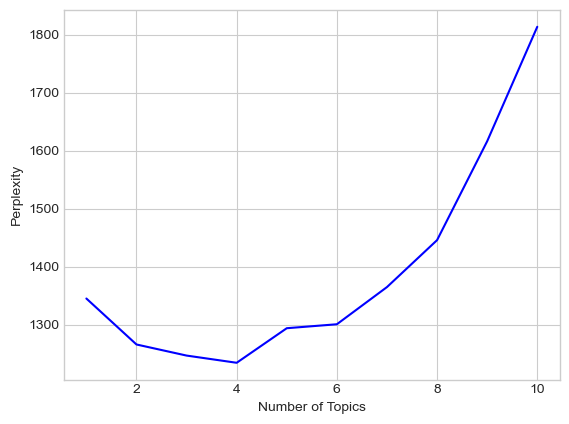

In [20]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

# 手动创建拼写替换字典
SPELL_REPLACE_DICT = {
    'monke': 'monkey',
    'bos': 'boss',
    # 添加更多常见的拼写错误和正确拼写
}

# --------------------- 数据预处理 ---------------------
def preprocess(texts):
    """
    文本预处理流水线
    输入：原始文本列表
    输出：处理后的分词列表
    """
    # 初始化工具
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    processed_texts = []
    for text in texts:
        # 去除非字母字符并小写化
        clean_text = re.sub('[^a-zA-Z]', ' ', text).lower()
        # 分词处理
        words = clean_text.split()
        
        # 手动拼写修正
        words = [SPELL_REPLACE_DICT.get(word, word) for word in words]
        
        # 去停用词+词形还原
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 3]
        processed_texts.append(words)
    return processed_texts

# --------------------- 模型训练 ---------------------
def train_lda(docs, num_topics=10, passes=15):
    """
    LDA模型训练流程
    返回：模型、词典、文档-主题分布
    """
    # 创建词典
    dictionary = corpora.Dictionary(docs)
    # 过滤极端值
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    # 生成语料库
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    # 训练LDA模型
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        passes=passes,
        alpha='auto'
    )
    
    return lda_model, corpus, dictionary

# --------------------- 结果分析 ---------------------
def visualize_lda(lda_model, corpus, dictionary):
    """生成交互式可视化"""
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis, 'lda_visualization.html')

def plot_perplexity(docs, dictionary, max_topics=10):
    """困惑度分析"""
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    perplexities = []
    for n_topics in range(1, max_topics+1):
        model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=10)
#        perplexity = model.log_perplexity(corpus)
        log_perplexity = model.log_perplexity(corpus)
        perplexity = np.exp(-log_perplexity)  # 将对数困惑度转换为困惑度
        perplexities.append(perplexity)
        print(f"{n_topics} : {perplexity:.4f}")  # 输出主题数和对应的困惑度
    
    plt.plot(range(1, max_topics+1), perplexities, 'b-')
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    plt.savefig('perplexity_curve.png')

# 主程序
if __name__ == "__main__":
    df = pd.read_csv('wukong_english_filterRecent_V2_washBase.csv')  # 修改为你的文件名
    df['review'] = df['review'].astype(str)  # 强制转换为字符串
    
    # 假设数据已加载为df['review']
    texts = df['review'].tolist()
    print("text finished\n")
    
    # 预处理（预计耗时：30-60分钟）
    processed_docs = preprocess(texts)
    print("preprocess finished\n")
    
    # 确定最佳主题数（预计耗时：2-4小时）
    temp_dict = corpora.Dictionary(processed_docs)
    print("corpora finished\n")
    plot_perplexity(processed_docs, temp_dict)
    print("plot corpora finished\n")
    
    # 正式训练
    lda_model, corpus, dictionary = train_lda(processed_docs, num_topics=4)
    print("train_LDA finished\n")
    
    # 可视化输出
    visualize_lda(lda_model, corpus, dictionary)
    
    # 查看主题词
    print(lda_model.print_topics())